[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jfcrenshaw/pzflow/blob/main/examples/nongaussian_errors.ipynb)

If running in Colab, to switch to GPU, go to the menu and select Runtime -> Change runtime type -> Hardware accelerator -> GPU.

In addition, uncomment and run the following code:

In [ ]:
# !pip install pzflow

------------------
## Convolving non-Gaussian errors

This notebook demonstrates how to train a flow on data that has non-Gaussian errors/uncertainties, as well as convolving those errors in log_prob and posterior calculations.
We will use the [redshift example](https://github.com/jfcrenshaw/pzflow/blob/main/examples/redshift_example.ipynb) again.

For an example of how to handle Gaussian errors, which is much easier, see [this notebook](https://github.com/jfcrenshaw/pzflow/blob/main/examples/nongaussian_errors.ipynb).

In [1]:
import jax.numpy as np
from jax import random
import matplotlib.pyplot as plt

import pzflow
from pzflow import Flow
from pzflow.bijectors import Chain, InvSoftplus, StandardScaler, RollingSplineCoupling
from pzflow.examples import get_galaxy_data

First let's load the example galaxy data set included with `pzflow`, and include photometric errors. For simplicity, we will assume all bands have error = 0.1

In [2]:
data = get_galaxy_data()
for col in data.columns[1:]:
    data[f"{col}_err"] = 0.1 * np.ones(data.shape[0])
data.head()

,redshift,u,g,r,i,z,y,u_err,g_err,r_err,i_err,z_err,y_err
0,0.287087,26.759261,25.901778,25.187710,24.932318,24.736903,24.671623,0.1,0.1,0.1,0.1,0.1,0.1
1,0.293313,27.428358,26.679299,25.977161,25.700094,25.522763,25.417632,0.1,0.1,0.1,0.1,0.1,0.1
2,1.497276,27.294001,26.068798,25.450055,24.460507,23.887221,23.206112,0.1,0.1,0.1,0.1,0.1,0.1
3,0.283310,28.154075,26.283166,24.599570,23.723491,23.214108,22.860012,0.1,0.1,0.1,0.1,0.1,0.1
4,1.545183,29.276065,27.878301,27.333528,26.543374,26.061941,25.383056,0.1,0.1,0.1,0.1,0.1,0.1


We will use the same bijector as we used in the [redshift example notebook](https://github.com/jfcrenshaw/pzflow/blob/main/examples/redshift_example.ipynb).

In [3]:
columns = ["redshift"] + list("ugrizy")

# set the inverse softplus parameters, 
# to ensure that sampled redshifts are positive
column_idx = 0
sharpness = 10

# calculate the mean and standard deviations of the dimensions
means = data[columns].mean(axis=0).values
stds = data[columns].std(axis=0).values

# set number of layers in the RollingSplineCoupling
# equal to the input dimension
nlayers = len(columns)

# construct our bijector
# by chaining all these layers
bijector = Chain(
    InvSoftplus(column_idx, sharpness),
    StandardScaler(means, stds),
    RollingSplineCoupling(nlayers),
)

Now, we need to build the machinery to handle non-Gaussian errors. pzflow convolves errors by sampling from an error model, which by default is Gaussian. If we want to convolve non-Gaussian errors, we need to pass the `Flow` constructor an error model that tells it how to sample from our non-Gaussian distribution.

The error model must be a callable that takes the following arguments:
- key is a jax rng key, e.g. jax.random.PRNGKey(0)
- X is a 2 dimensional array of data variables, where the order of variables matches the order of the columns in data_columns
- Xerr is the corresponding 2 dimensional array of errors
- nsamples is the number of samples to draw from the error distribution

and it must return an array of samples with the shape `(X.shape[0], nsamples, X.shape[1])`

Below we build a photometric error model, which takes the exponential of the magnitudes to convert to flux values, adds Gaussian flux errors, then takes the log to convert back to magnitudes. 

In [4]:
def photometric_error_model(
    key,
    X: np.ndarray,
    Xerr: np.ndarray,
    nsamples: int,
) -> np.ndarray:
    
    # calculate fluxes
    F = 10 ** (X / -2.5)
    # calculate flux errors
    dF = np.log(10) / 2.5 * F * Xerr
    
    # add Gaussian errors
    eps = random.normal(key, shape=(F.shape[0], nsamples, F.shape[1]))
    F = F[:, None, :] + eps * dF[:, None, :]
    
    # add a flux floor to avoid infinite magnitudes
    # this flux corresponds to a max magnitude of 30
    F = np.clip(F, 1e-12, None)
    
    # calculate magnitudes
    M = -2.5 * np.log10(F)
    
    return M

Now we can construct the Flow, this time passing the error model

In [5]:
flow = Flow(
    columns, 
    bijector,
    data_error_model=photometric_error_model,
)

Now that we have set up the Flow with the new error model, we can train the flow, calculate posteriors, etc. just like we did in the [Gaussian error example](https://github.com/jfcrenshaw/pzflow/blob/main/examples/nongaussian_errors.ipynb).

For example, to train with error convolution:

In [6]:
%%time
losses = flow.train(data, epochs=200, convolve_errs=True, verbose=True)

Training 200 epochs 
Loss:
(0) 13.6907
(1) 1.2277
(11) -0.1433
(21) -0.1732
(31) -0.1399
(41) -0.1884
(51) -0.0906
(61) -0.0790
(71) -0.0818
(81) -0.1196
(91) -0.1789
(101) -0.1075
(111) -0.1796
(121) -0.0932
(131) -0.1429
(141) -0.1482
(151) -0.1054
(161) -0.0890
(171) -0.1193
(181) -0.2242
(191) -0.0393
(200) -0.1469
CPU times: user 3min 35s, sys: 2min 13s, total: 5min 48s
Wall time: 2min 41s


And to calculate posteriors with error convolution:

In [9]:
grid = np.linspace(0, 3, 100)
pdfs = flow.posterior(data[:10], column="redshift", grid=grid, err_samples=int(1e3))

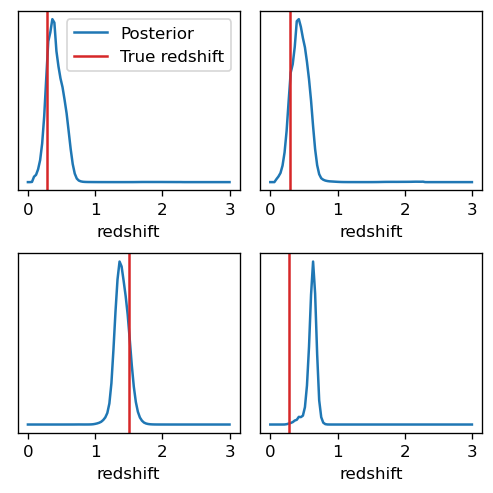

In [19]:
fig, axes = plt.subplots(2, 2, figsize=(4, 4), dpi=120, constrained_layout=True)

for i, ax in enumerate(axes.flatten()):
    
    ax.plot(grid, pdfs[i], label="Posterior")
    ax.axvline(data["redshift"][i], c="C3", label="True redshift")
    ax.set(xlabel="redshift", yticks=[])

axes[0,0].legend()
plt.show()